# Document budget closure

Starting with local budget closure (vertically integrated, following https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Closing_tracer_budgets.html )

Then trying to close budgets using restarts, but possibly missing diagnostics at open boundary?

Used a special 2x1day run (with extra diags, and some more added after 1 day):

`/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cmo
import gsw
from xhistogram.xarray import histogram as xhistogram
from matplotlib import ticker, cm, colors

import warnings
warnings.simplefilter("ignore")


In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32839,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46851,Total threads: 1
Dashboard: /proxy/43195/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:45805,


In [3]:
# load heat budget stuff from additional diagnostics
base = '/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/'
ocean_native_heat = xr.open_mfdataset(base + 'output049/ocean_native_heat.nc')
ocean_native_salt = xr.open_mfdataset(base + 'output049/ocean_native_salt.nc')
ocean_native_thck = xr.open_mfdataset(base + 'output049/ocean_native_thck.nc')
ocean_native_snap = xr.open_mfdataset(base + 'output049/ocean_native_snap.nc')


In [4]:
# load intake ds

pathmain = "/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/"
columns = [
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
chunk_dict = {
	        'time' : 1,
	        'yq' : 1443,
	        'xq' : 4321,
            'yh':1442,
            'xh':4320,
            'yT':1442,
            'xT':4320,
    
	    }

esm_datastore = intake.open_esm_datastore(
    pathmain + "experiment_datastore.json", 
    columns_with_iterables= columns)


In [5]:
#find consecutive restarts
# time = 1903-12-02
restart048_T = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart048/access-om3.mom6.r.1903-12-02-00000.nc',
                                decode_timedelta = False)
restart048_S = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart048/access-om3.mom6.r.1903-12-02-00000_1.nc',
                                 decode_timedelta = False)
restart048_h = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart048/access-om3.mom6.r.1903-12-02-00000_2.nc',
                                 decode_timedelta = False)
# time = 1903-12-03
restart049_T = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart049/access-om3.mom6.r.1903-12-03-00000.nc',
                                decode_timedelta = False)
restart049_S = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart049/access-om3.mom6.r.1903-12-03-00000_1.nc',
                                 decode_timedelta = False)
restart049_h = xr.open_mfdataset('/scratch/x77/cy8964/access-om3/archive/ice_shelf_panan-PR-061025-nofrazilshelf-tideson-budgetdiags/restart049/access-om3.mom6.r.1903-12-03-00000_2.nc',
                                 decode_timedelta = False)


In [6]:
areacello = esm_datastore.search(variable="areacello").to_dask(xarray_open_kwargs={'decode_timedelta':True})
areacello = areacello.areacello.rename({'xh':'lonh','yh':'lath'})

### First let's check if the online tendency diags match the tendency computed from restarts

In [7]:
online_heat_tendency_49_48 = (ocean_native_heat.opottemptend*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*3600*24
online_salt_tendency_49_48 = (ocean_native_salt.osalttend*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*3600*24
online_vol_tendency_49_48 = (ocean_native_thck.dhdt*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*3600*24

# compute change in total heat
Cp = 3992.0 
rho0 = 1035
heat_global_48 = (restart048_T.Temp*rho0*Cp*restart048_h.h * areacello).sum().values
heat_global_49 = (restart049_T.Temp*rho0*Cp*restart049_h.h * areacello).sum().values
restart_heat_tendency_49_48 = heat_global_49-heat_global_48
print('online heat tendency', online_heat_tendency_49_48/1e12,'x10^12 J')
print('restart heat tendency', restart_heat_tendency_49_48/1e12,'x10^12 J')

# compute change in total salt: salt ~ salinity*density*volume in g, divide by 1000 for kg - noting my restarts are in practical salinity not absolute
salt_mass_global_48 = (restart048_S.Salt*rho0*restart048_h.h * areacello).sum().values/1000 #g->kg
salt_mass_global_49 = (restart049_S.Salt*rho0*restart049_h.h * areacello).sum().values/1000 #g->kg
restart_salt_tendency_49_48 = salt_mass_global_49-salt_mass_global_48
print('online salt tendency', online_salt_tendency_49_48/1e12,'x10^12 kg')
print('restart salt tendency', restart_salt_tendency_49_48/1e12,'x10^12 kg')

# compute change in total volume
vol_global_48 = (restart048_h.h * areacello).sum().values
vol_global_49 = (restart049_h.h * areacello).sum().values
restart_vol_tendency_49_48 = vol_global_49-vol_global_48
print('restart vol tendency',restart_vol_tendency_49_48/1e12,'x10^12 m^3')
print('online vol tendency',online_vol_tendency_49_48/1e12,'x10^12 m^3')


online heat tendency 745899692.6106629 x10^12 J
restart heat tendency 745899692.6116759 x10^12 J
online salt tendency -0.6723301275760115 x10^12 kg
restart salt tendency -0.67233012736 x10^12 kg
restart vol tendency 0.199874932928 x10^12 m^3
online vol tendency 0.1998749329245049 x10^12 m^3


hence restarts do capture the tendency - so I am computing them correctly e.g. with rho0 value.

### Now do vertically integrated budgets

Modified from https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Closing_tracer_budgets.html

Only outputted native coordinate budget terms.

In [8]:
# Specify budget terms
terms = {}
terms['heat'] = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
                 'boundary_forcing_heat_tendency','opottempdiff',#'opottemppmdiff',
                 'frazil_heat_tendency']#,'internal_heat_heat_tendency']
terms['salt'] = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
                 'boundary_forcing_salt_tendency','osaltdiff']#,'osaltpmdiff']
terms['thickness'] = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
                      'boundary_forcing_h_tendency']


In [9]:
def sum_vertically(arr):
    return arr.sum('zl')


In [10]:
# compute heat budget terms, and print integrated values (over full domain and in time)

## heat budget
print('---- Heat ----')
print(terms['heat'][0],(ocean_native_heat[terms['heat'][0]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 J')
heat_LHS = sum_vertically(ocean_native_heat.opottemptend)
heat_RHS = xr.zeros_like(heat_LHS)
for i in range(len(terms['heat'][1:])):
    print(terms['heat'][i+1],(ocean_native_heat[terms['heat'][i+1]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 J')
    heat_RHS += sum_vertically(ocean_native_heat[terms['heat'][i+1]])
print('LHS - RHS', ((heat_LHS - heat_RHS)*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 J')

## salt budget
print('---- Salt ----')
print(terms['salt'][0],(ocean_native_salt[terms['salt'][0]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 kg')
salt_LHS = sum_vertically(ocean_native_salt.osalttend)
salt_RHS = xr.zeros_like(heat_LHS)
for i in range(len(terms['salt'][1:])):
    print(terms['salt'][i+1],(ocean_native_salt[terms['salt'][i+1]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 kg')
    salt_RHS += sum_vertically(ocean_native_salt[terms['salt'][i+1]])
print('LHS - RHS', ((salt_LHS - salt_RHS)*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 kg')

## volume budget
print('---- Thickness ----')
print(terms['thickness'][0],(ocean_native_thck[terms['thickness'][0]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 m^3')
thickness_LHS = sum_vertically(ocean_native_thck.dhdt)
thickness_RHS = xr.zeros_like(heat_LHS)
for i in range(len(terms['thickness'][1:])):
    print(terms['thickness'][i+1],(ocean_native_thck[terms['thickness'][i+1]]*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 m^3')
    thickness_RHS += sum_vertically(ocean_native_thck[terms['thickness'][i+1]])
print('LHS - RHS', ((thickness_LHS - thickness_RHS)*areacello.rename({'lath':'yh','lonh':'xh'})).sum().values*24*3600/1e12,'10^12 m^3')


---- Heat ----
opottemptend 745899692.6106629 10^12 J
T_advection_xy 20381542.26049175 10^12 J
Th_tendency_vert_remap -2.43e-06 10^12 J
boundary_forcing_heat_tendency 724504458.7499439 10^12 J
opottempdiff 2.025e-09 10^12 J
frazil_heat_tendency 1013691.6002302895 10^12 J
LHS - RHS -7.611056914011353e-07 10^12 J
---- Salt ----
osalttend -0.6723301275760115 10^12 kg
S_advection_xy -1.989250368406842 10^12 kg
Sh_tendency_vert_remap -1.1242618560791016e-10 10^12 kg
boundary_forcing_salt_tendency 1.3169202409410412 10^12 kg
osaltdiff -2.9761078767478467e-12 10^12 kg
LHS - RHS 5.2029371140889736e-12 10^12 kg
---- Thickness ----
dhdt 0.1998749329245049 10^12 m^3
dynamics_h_tendency -0.09644814678557295 10^12 m^3
vert_remap_h_tendency 7.38680362701416e-14 10^12 m^3
boundary_forcing_h_tendency 0.29632307970999244 10^12 m^3
LHS - RHS 1.139303169705468e-14 10^12 m^3


Text(0.5, 0.98, 'Native coordinate budgets, integrated vertically')

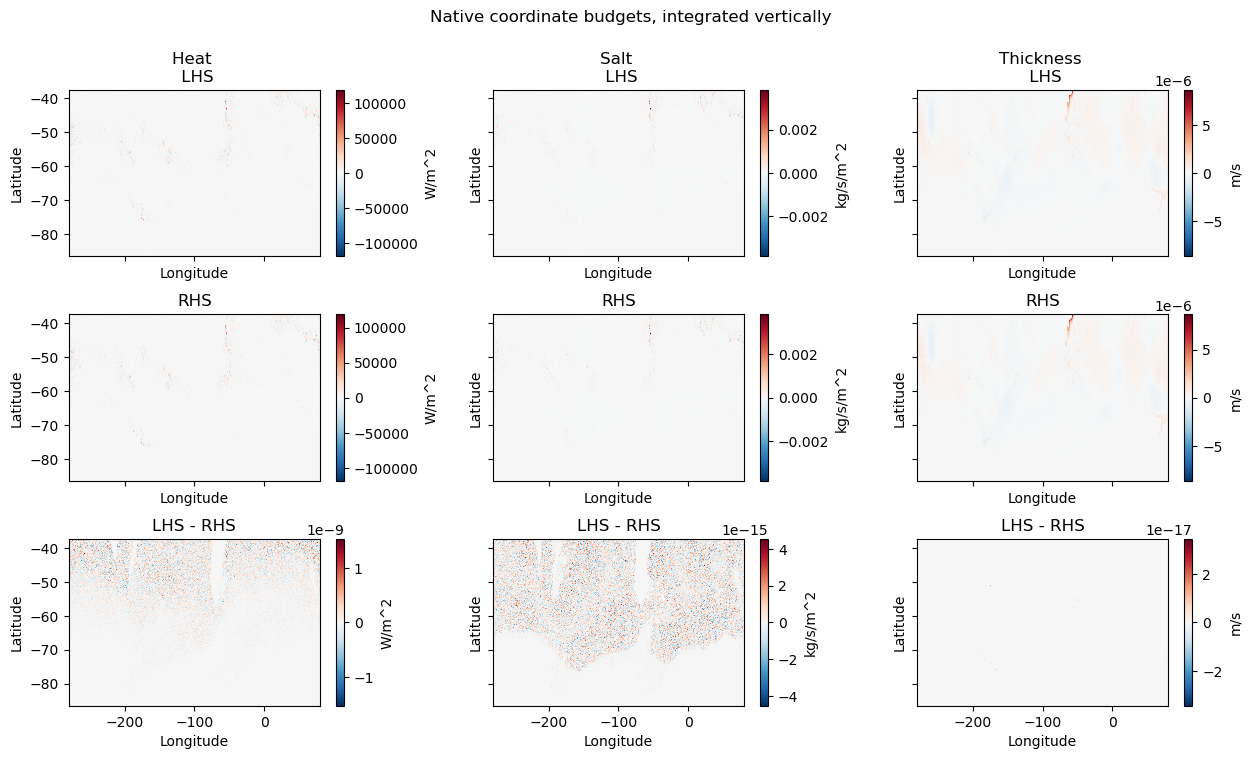

In [11]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15,8), sharex = True, sharey = True)
ax = np.ravel(axes)

heat_LHS.plot(ax = ax[0], cbar_kwargs = {'label':'W/m^2'})
ax[0].set_title('Heat \n LHS')
heat_RHS.plot(ax = ax[3], cbar_kwargs = {'label':'W/m^2'})
ax[3].set_title('RHS')
(heat_LHS-heat_RHS).plot(ax = ax[6], cbar_kwargs = {'label':'W/m^2'})
ax[6].set_title('LHS - RHS')

salt_LHS.plot(ax = ax[1], cbar_kwargs = {'label':'kg/s/m^2'})
ax[1].set_title('Salt \n LHS')
salt_RHS.plot(ax = ax[4], cbar_kwargs = {'label':'kg/s/m^2'})
ax[4].set_title('RHS')
(salt_LHS-salt_RHS).plot(ax = ax[7], cbar_kwargs = {'label':'kg/s/m^2'})
ax[7].set_title('LHS - RHS')

thickness_LHS.plot(ax = ax[2], cbar_kwargs = {'label':'m/s'})
ax[2].set_title('Thickness \n LHS')
thickness_RHS.plot(ax = ax[5], cbar_kwargs = {'label':'m/s'})
ax[5].set_title('RHS')
(thickness_LHS-thickness_RHS).plot(ax = ax[8], cbar_kwargs = {'label':'m/s'})
ax[8].set_title('LHS - RHS')

for i in np.arange(9):
    ax[i].set_xlabel('Longitude')
    ax[i].set_ylabel('Latitude')
    

fig.subplots_adjust(hspace = 0.35, wspace = 0.35)
fig.suptitle('Native coordinate budgets, integrated vertically')

## Vertically integrated budgets close everywhere, using diagnosed tendency terms. Yay!

## Now try to close budget using normal diagnostics and restarts....

Use 2D data as the scalar "totals" are snapshots

### Heat

`net_heat_coupler = hfds-hfrainds-hfrunoffds-frazil_heat_tendency_2d`

And `net_heat_coupler + frazil_heat_tendency_2d` is close to diag `boundary_forcing_heat_tendency 724504458.7499439 10^12 J`

`boundary_forcing_heat_tendency 724504458.7499439 10^12 J` + `frazil_heat_tendency 1013691.6002302895 10^12 J` = `725518` ??

In [12]:
# compute change in total heat
Cp = 3992.0 
rho0 = 1035
heat_global_48 = (restart048_T.Temp*rho0*Cp*restart048_h.h * areacello).sum().values
heat_global_49 = (restart049_T.Temp*rho0*Cp*restart049_h.h * areacello).sum().values

print('difference in heat_global',heat_global_49-heat_global_48,'J')

net_heat_coupler = esm_datastore.search(variable="net_heat_coupler").to_dask(xarray_open_kwargs={'decode_timedelta':True})
net_heat_coupler = net_heat_coupler.net_heat_coupler.sel(time = slice('1903-12-02','1903-12-03'))
total_net_heat_coupler = (net_heat_coupler*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
total_net_heat_coupler_49_48 = total_net_heat_coupler.sum('time')*24*3600#*30 #time in s in output period
print('total_net_heat_coupler_flux',total_net_heat_coupler_49_48.values,'J')

hfds = esm_datastore.search(variable="hfds").to_dask(xarray_open_kwargs={'decode_timedelta':True})
hfds = hfds.hfds.sel(time = slice('1903-12-02','1903-12-03'))
total_hfds = (hfds*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
total_hfds_49_48 = total_hfds.sum('time')*24*3600#*30 #time in s in output period
print('total_hfds',total_hfds_49_48.values,'J')

frazil_heat_tendency_2d = esm_datastore.search(variable="frazil_heat_tendency_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
frazil_heat_tendency_2d = frazil_heat_tendency_2d.frazil_heat_tendency_2d.sel(time = slice('1903-12-02','1903-12-03'))
total_frazil_heat_tendency_2d_49_48 = ((frazil_heat_tendency_2d)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh']).sum('time').values*24*3600
print('total frazil_heat_tendency_2d',total_frazil_heat_tendency_2d_49_48,'J')

print('total frazil_heat_tendency_2d + total_net_heat_coupler_flux',total_frazil_heat_tendency_2d_49_48+total_net_heat_coupler_49_48.values,'J')


T_ady_2d = esm_datastore.search(variable="T_ady_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
T_ady_2d = T_ady_2d.T_ady_2d.sel(time = slice('1903-12-02','1903-12-03'))
T_diffy_2d = esm_datastore.search(variable="T_diffy_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
T_diffy_2d = T_diffy_2d.T_diffy_2d.sel(time = slice('1903-12-02','1903-12-03'))
#T_hbd_diffy_2d = esm_datastore.search(variable="T_hbd_diffy_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
#T_hbd_diffy_2d = T_hbd_diffy_2d.T_hbd_diffy_2d.sel(time = slice('1903-12-02','1903-12-03'))

heat_transport_north = (T_ady_2d + T_diffy_2d).isel(yq = -1).sum()*3600*24
print('Northern boundary heat transport',heat_transport_north.values,'J')

print('residual heat change -net_heat_coupler_flux - frazil + northern boundary ',heat_global_49-heat_global_48 - total_net_heat_coupler_49_48.values - total_frazil_heat_tendency_2d_49_48 + heat_transport_north.values,'J')

difference in heat_global 7.458996926116759e+20 J
total_net_heat_coupler_flux 7.237277871300586e+20 J
total_hfds 7.308367146569596e+20 J
total frazil_heat_tendency_2d 1.0136916020911131e+18 J
total frazil_heat_tendency_2d + total_net_heat_coupler_flux 7.247414787321497e+20 J
Northern boundary heat transport -2.042959e+19 J
residual heat change -net_heat_coupler_flux - frazil + northern boundary  7.286237304249385e+17 J


<span style="color:red">Not sure which variable is meant to go here?</span> Wondering if open boundary is treated in diagnostics - would there be an open boundary contribution to x direction heat transport too?

MOM.f90 (https://github.com/ACCESS-NRI/MOM6/blob/ice-shelf-dev/src/core/MOM.F90#L4853) comments suggest `hfds`  but that has more of a residual than `net_heat_coupler + frazil`
```
!!  Depth integrated heat budget diagnostic for MOM.
!!
!! * OPOTTEMPTEND_2d = T_ADVECTION_XY_2d + OPOTTEMPPMDIFF_2d + HFDS + HFGEOU
!!
!! * T_ADVECTION_XY_2d = horizontal advection
!! * OPOTTEMPPMDIFF_2d = neutral diffusion
!! * HFDS              = net surface boundary heat flux
!! * HFGEOU            = geothermal heat flux
!!
!! * HFDS = net surface boundary heat flux entering the ocean
!!        = rsntds + rlntds + hfls + hfss + heat_pme + hfsifrazil
!!
!! * More heat flux cross-checks
!!   * hfds     = net_heat_coupler + hfsifrazil + heat_pme
!!   * heat_pme = heat_content_surfwater
!!              = heat_content_massin + heat_content_massout
!!              = heat_content_fprec + heat_content_cond + heat_content_vprec
!!               + hfrunoffds + hfevapds + hfrainds

```

### Salt

`total_salt_flux = total_salt_Flux_In + total_salt_Flux_Added`

`sfdsi` is the CMOR name for `salt_flux`

In [13]:
# compute change in total salt: salt ~ salinity*density*volume in g, divide by 1000 for kg - noting my restarts are in practical salinity not absolute
rho0 = 1035
salt_mass_global_48 = (restart048_S.Salt*rho0*restart048_h.h * areacello).sum().values/1000 #g->kg
salt_mass_global_49 = (restart049_S.Salt*rho0*restart049_h.h * areacello).sum().values/1000 #g->kg
print('difference in salt_mass_global',(salt_mass_global_49-salt_mass_global_48)/1e12,'x10^12 kg')

# load net sfdsi
sfdsi = esm_datastore.search(variable="sfdsi").to_dask(xarray_open_kwargs={'decode_timedelta':True})
sfdsi = sfdsi.sfdsi.sel(time = slice('1903-12-02','1903-12-03'))
total_sfdsi_flux = (sfdsi*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
total_sfdsi_flux_49_48 = total_sfdsi_flux.sum('time')*24*3600#*30 #time in s in output period
print('total_sfdsi_flux',total_sfdsi_flux_49_48.values/1e12,'x10^12 kg')

S_ady_2d = esm_datastore.search(variable="S_ady_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
S_ady_2d = S_ady_2d.S_ady_2d.sel(time = slice('1903-12-02','1903-12-03'))
S_diffy_2d = esm_datastore.search(variable="S_diffy_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
S_diffy_2d = S_diffy_2d.S_diffy_2d.sel(time = slice('1903-12-02','1903-12-03'))

salt_transport_north = (S_ady_2d + S_diffy_2d).isel(yq = -1).sum()*3600*24
print('Northern boundary salt transport',salt_transport_north.values/1e12,'x10^12 kg')

print('residual',(salt_mass_global_49-salt_mass_global_48)/1e12 -total_sfdsi_flux_49_48.values/1e12 + salt_transport_north.values/1e12,'x10^12 kg')

difference in salt_mass_global -0.67233012736 x10^12 kg
total_sfdsi_flux 1.3169202410411798 x10^12 kg
Northern boundary salt transport 1.921336999936 x10^12 kg
residual -0.06791336846517981 x10^12 kg


<span style="color:red">Not sure about this</span>


# Volume

In [14]:
# compute change in total volume
rho0 = 1035
vol_global_48 = (restart048_h.h * areacello).sum().values
vol_global_49 = (restart049_h.h * areacello).sum().values
print('difference in vol_global',(vol_global_49-vol_global_48)/1e12,'x10^12 m^3')
print('difference in mass_global',(vol_global_49-vol_global_48)*rho0/1e15,'x1e15 kg')

difference in vol_global 0.199874932928 x10^12 m^3
difference in mass_global 0.20687055558048 x1e15 kg


In [15]:
# fw flux
wfo = esm_datastore.search(variable="wfo").to_dask(xarray_open_kwargs={'decode_timedelta':True})
wfo = wfo.wfo.sel(time = slice('1903-12-02','1903-12-03'))
total_wfo_flux = (wfo*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
total_wfo_flux_48_47 = total_wfo_flux.sum('time')*24*3600#*30 #time in s in output period
print('total_wfo_flux',total_wfo_flux_48_47.values/1e15,'x1e15 kg')
print('total_wfo_flux converted to volume',total_wfo_flux_48_47.values/1e12/rho0,'x1e12 m^3')



total_wfo_flux 0.306694387508744 x1e15 kg
total_wfo_flux converted to volume 0.29632307971859323 x1e12 m^3


In [16]:
vh = esm_datastore.search(variable="vh").to_dask(xarray_open_kwargs={'decode_timedelta':True})
vh = vh.vh.sel(time = slice('1903-12-02','1903-12-03'))
#dxt = esm_datastore.search(variable="dxt", file_id = 'access_om3_mom6_static').to_dask(xarray_open_kwargs={'decode_timedelta':True})
volume_transport_north = (vh.isel(yq = -1)).sum()*3600*24
print('Northern boundary volume transport',volume_transport_north.values/1e12,'x10^12 m^3')


Northern boundary volume transport 0.096446595072 x10^12 m^3


In [17]:
print('residual', (vol_global_49-vol_global_48)/1e12-total_wfo_flux_48_47.values/1e12/rho0+volume_transport_north.values/1e12,'x10^12 m^3')

residual -1.551718593242879e-06 x10^12 m^3


### So volume budget pretty nicely closed by wfo + vh


### Try again with heat

In [27]:
# try being away from the open boundary?

# compute change in total heat
Cp = 3992.0 
rho0 = 1035
heat_global_48 = (restart048_T.Temp*rho0*Cp*restart048_h.h * areacello).isel(lath = np.arange(0,1430)).sum().values
heat_global_49 = (restart049_T.Temp*rho0*Cp*restart049_h.h * areacello).isel(lath = np.arange(0,1430)).sum().values

print('difference in heat_global',heat_global_49-heat_global_48,'J')

net_heat_coupler = esm_datastore.search(variable="net_heat_coupler").to_dask(xarray_open_kwargs={'decode_timedelta':True})
net_heat_coupler = net_heat_coupler.net_heat_coupler.sel(time = slice('1903-12-02','1903-12-03'))
total_net_heat_coupler = (net_heat_coupler*areacello.rename({'lath':'yh','lonh':'xh'})).isel(yh = np.arange(0,1430)).sum(['xh','yh'])
total_net_heat_coupler_49_48 = total_net_heat_coupler.sum('time')*24*3600#*30 #time in s in output period
print('total_net_heat_coupler_flux',total_net_heat_coupler_49_48.values,'J')

hfds = esm_datastore.search(variable="hfds").to_dask(xarray_open_kwargs={'decode_timedelta':True})
hfds = hfds.hfds.sel(time = slice('1903-12-02','1903-12-03'))
total_hfds = (hfds*areacello.rename({'lath':'yh','lonh':'xh'})).isel(yh = np.arange(0,1430)).sum(['xh','yh'])
total_hfds_49_48 = total_hfds.sum('time')*24*3600#*30 #time in s in output period
print('total_hfds',total_hfds_49_48.values,'J')

frazil_heat_tendency_2d = esm_datastore.search(variable="frazil_heat_tendency_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
frazil_heat_tendency_2d = frazil_heat_tendency_2d.frazil_heat_tendency_2d.sel(time = slice('1903-12-02','1903-12-03'))
total_frazil_heat_tendency_2d_49_48 = ((frazil_heat_tendency_2d)*areacello.rename({'lath':'yh','lonh':'xh'})).isel(yh = np.arange(0,1430)).sum(['xh','yh']).sum('time').values*24*3600
print('total frazil_heat_tendency_2d',total_frazil_heat_tendency_2d_49_48,'J')

print('total frazil_heat_tendency_2d + total_net_heat_coupler_flux',total_frazil_heat_tendency_2d_49_48+total_net_heat_coupler_49_48.values,'J')


T_ady_2d = esm_datastore.search(variable="T_ady_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
T_ady_2d = T_ady_2d.T_ady_2d.sel(time = slice('1903-12-02','1903-12-03'))
T_diffy_2d = esm_datastore.search(variable="T_diffy_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
T_diffy_2d = T_diffy_2d.T_diffy_2d.sel(time = slice('1903-12-02','1903-12-03'))
#T_hbd_diffy_2d = esm_datastore.search(variable="T_hbd_diffy_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
#T_hbd_diffy_2d = T_hbd_diffy_2d.T_hbd_diffy_2d.sel(time = slice('1903-12-02','1903-12-03'))

heat_transport_north = (T_ady_2d + T_diffy_2d).isel(yq = np.arange(0,1431)).isel(yq = -1).sum()*3600*24
print('Northern boundary heat transport',heat_transport_north.values,'J')

print('residual heat change -net_heat_coupler_flux - frazil + northern boundary ',heat_global_49-heat_global_48 - total_net_heat_coupler_49_48.values - total_frazil_heat_tendency_2d_49_48 + heat_transport_north.values,'J')

difference in heat_global 7.263517276227282e+20 J
total_net_heat_coupler_flux 6.986345920353778e+20 J
total_hfds 7.052085019037177e+20 J
total frazil_heat_tendency_2d 1.0136916020911131e+18 J
total frazil_heat_tendency_2d + total_net_heat_coupler_flux 6.996482836374689e+20 J
Northern boundary heat transport -2.6071622e+19 J
residual heat change -net_heat_coupler_flux - frazil + northern boundary  6.318220684115313e+17 J


In [26]:
# load net heating
hfds = esm_datastore.search(variable="hfds").to_dask(xarray_open_kwargs={'decode_timedelta':True})
hfds = hfds.hfds.sel(time = slice('1903-12-02','1903-12-03'))
hfrainds = esm_datastore.search(variable="hfrainds").to_dask(xarray_open_kwargs={'decode_timedelta':True})
hfrainds = hfrainds.hfrainds.sel(time = slice('1903-12-02','1903-12-03'))
hfrunoffds = esm_datastore.search(variable="hfrunoffds").to_dask(xarray_open_kwargs={'decode_timedelta':True})
hfrunoffds = hfrunoffds.hfrunoffds.sel(time = slice('1903-12-02','1903-12-03'))
frazil_heat_tendency_2d = esm_datastore.search(variable="frazil_heat_tendency_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
frazil_heat_tendency_2d = frazil_heat_tendency_2d.frazil_heat_tendency_2d.sel(time = slice('1903-12-02','1903-12-03'))

print('total hfds',((hfds)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh']).sum('time').values*24*3600,'J')
print('total hfrainds',((hfrainds)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh']).sum('time').values*24*3600,'J')
print('total hfrunoffds',((hfrunoffds)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh']).sum('time').values*24*3600,'J')
print('total frazil_heat_tendency_2d',((frazil_heat_tendency_2d)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh']).sum('time').values*24*3600,'J')

sum_heat_flux = ((hfds-hfrainds-hfrunoffds-frazil_heat_tendency_2d)*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
sum_heat_flux_49_48 = sum_heat_flux.sum('time')*24*3600#*30 #time in s in output period
print('total_heat_flux',sum_heat_flux_49_48.values,'J')

net_heat_coupler = esm_datastore.search(variable="net_heat_coupler").to_dask(xarray_open_kwargs={'decode_timedelta':True})
net_heat_coupler = net_heat_coupler.net_heat_coupler.sel(time = slice('1903-12-02','1903-12-03'))
total_net_heat_coupler = (net_heat_coupler*areacello.rename({'lath':'yh','lonh':'xh'})).sum(['xh','yh'])
total_net_heat_coupler_49_48 = total_net_heat_coupler.sum('time')*24*3600#*30 #time in s in output period
print('total_net_heat_coupler_flux',total_net_heat_coupler_49_48.values,'J')


total hfds 7.308367146569596e+20 J
total hfrainds 6.120429116953179e+18 J
total hfrunoffds -2.5193186178260556e+16 J
total frazil_heat_tendency_2d 1.0136916020911131e+18 J
total_heat_flux 7.237277871361757e+20 J
total_net_heat_coupler_flux 7.237277871300586e+20 J


None of these match the required residual 7.286237304249385e+17 J

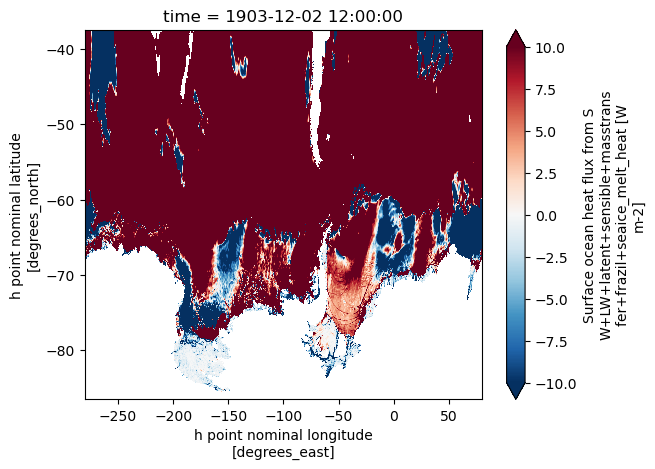

In [30]:
hfds.plot(vmax = 10)